# EDA

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Accessing

In [2]:
df = pd.read_csv('./aps_failure_training_set.csv', na_values='na')
print(df.shape)
df.head()

(60000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 78.3+ MB


### Define the categorical columns and numeriacl columns

In [8]:
target = 'class'
cat_cols = df.drop(columns=[target]).select_dtypes('object').columns
num_cols = df.drop(columns=[target]).select_dtypes(['float', 'int']).columns

len(cat_cols), len(num_cols)

(0, 146)

There are **no categorical column** in this dataset as this is a data from a **sensor**.

## Challenges and other objectives

- Need to Handle many Null values in almost all columns
- No low-latency requirement.
- Interpretability is not important.
- Mis-classification leads the unecessary repair costs.

In [5]:
df['class'].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

In [6]:
df['class'].value_counts(True)

class
neg    0.983333
pos    0.016667
Name: proportion, dtype: float64

Here, we can see that this dataset is highly imblanced with `neg` as **Majority** and `pos` as **Minority** variable in the target feature.

We need to **balance this target feature** using `SMOTETomek` class from `imblearn` library.

### Checking missing values

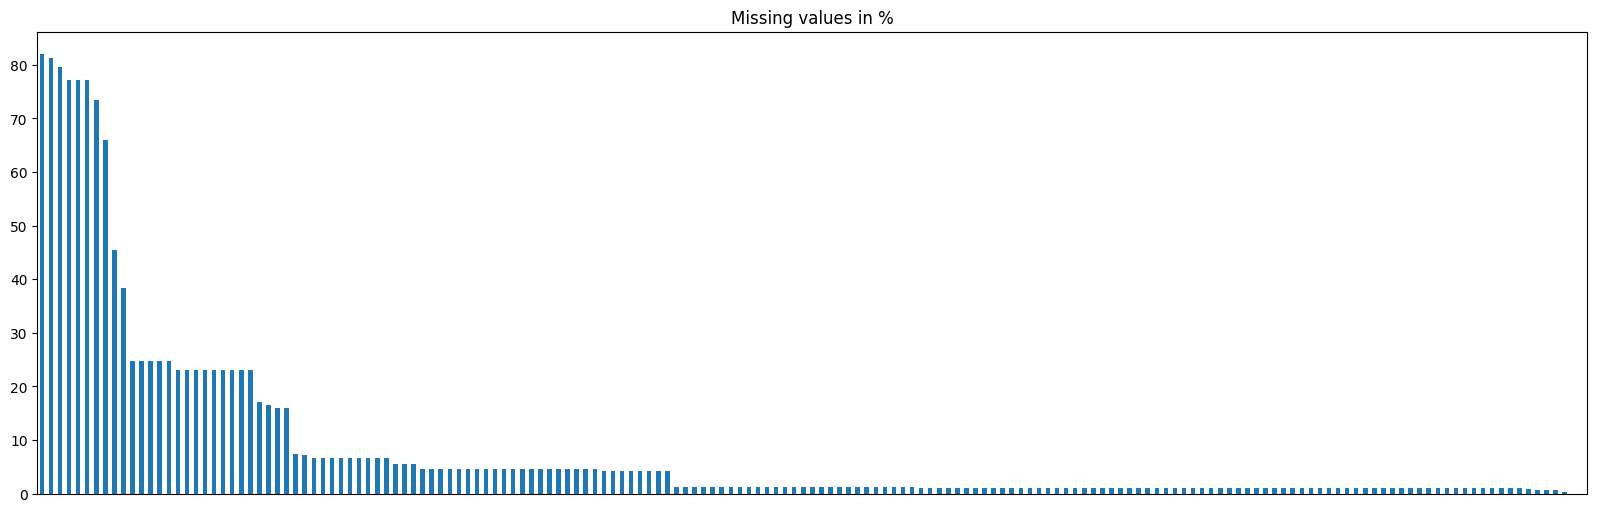

In [7]:
nan_values = (
    df.isna().sum()
    .div(df.shape[0]).mul(100)
    .sort_values(ascending=False)
)
nan_values.plot(kind='bar', xticks=[],
                title='Missing values in %', figsize=(20, 6))
plt.show()

#### Drop columns which has more than 70% values missing

In [8]:
df.drop(columns=nan_values[nan_values >= 20].index, inplace=True)

In [9]:
# Re-define the num_cols after dropping the columns
num_cols = df.drop(columns=[target]).select_dtypes(['float', 'int']).columns
len(num_cols)

146

#### Total percentage of missing values in whole dataset

In [10]:
f'Total percentage of missing values in whole dataset: {round(df.isna().sum().sum() / df.size, 4)}%'

'Total percentage of missing values in whole dataset: 0.0264%'

In [11]:
df.shape

(60000, 147)

In [13]:
df.to_csv('preprocessed.csv', index=False)

---
---
---

# Model Building

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from kneed import KneeLocator
from imblearn.combine import SMOTETomek

## Some important function for Model Building

In [2]:
def evaluate_model(y_true, y_pred):
    return {
        'accuracy_score': float(accuracy_score(y_true, y_pred)),
        'f1_score': float(f1_score(y_true, y_pred)),
        'precision_score': float(precision_score(y_true, y_pred)),
        'recall_score': float(recall_score(y_true, y_pred)),
        'roc_auc_score': float(roc_auc_score(y_true, y_pred)),
    }

In [3]:
def build_model_report(X, y, models: dict):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    models_list = []
    models_scores_report = {}
    confusion_matrix_report = {}

    for name, model in models.items():
        models_list.append(name)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        model_train_scores = evaluate_model(y_train ,y_train_pred)
        train_confusion_matrix = confusion_matrix(y_train, y_train_pred)

        y_test_pred = model.predict(X_test)
        model_test_scores = evaluate_model(y_test, y_test_pred)
        test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

        # Add scores and confusion matrix to report
        models_scores_report[name] = {
            'train_scores': model_train_scores,
            'test_scores': model_test_scores,
        }

        confusion_matrix_report[name] = {
            'train': train_confusion_matrix,
            'test': test_confusion_matrix,
        }

        print(f'{name:<20}: Training Scores')
        print('--'*27)
        for key, value in model_train_scores.items():
            print(f'{key:<20}: {value:.3f}')
        print('=='*25)

        print(f'{name:<20}: Testing Scores')
        print('--'*27)
        for key, value in model_test_scores.items():
            print(f'{key:<20}: {value:.3f}')
        print('=='*25)

    return models_list, models_scores_report, confusion_matrix_report

## Data Accessing

In [4]:
df = pd.read_csv('preprocessed.csv')
print(df.shape)
df.head()

(60000, 147)


,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,2.130706e+09,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,2.280000e+02,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,7.000000e+01,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,1.368000e+03,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


## Data Transformation

In [5]:
X = df.drop(columns=['class'])
y = df['class']

In [6]:
X.shape, y.shape

((60000, 146), (60000,))

### Encoding and Scaling the features

In [9]:
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', RobustScaler()),
])

target_encoder = LabelEncoder()

transformer = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
])

In [10]:
X_transformed = transformer.fit_transform(X)
y_transformed = target_encoder.fit_transform(y)

### Checking PCA effect on the dataset

In [ ]:
pca_var_ratio = {}
for n in range(2, 50):
    pc = PCA(n_components=n)
    df_pca = pc.fit(X_transformed)
    pca_var_ratio[n] = sum(df_pca.explained_variance_ratio_)

<Axes: title={'center': 'PCA Variation Plot'}, xlabel='n_components', ylabel='sum(pca_variation)'>

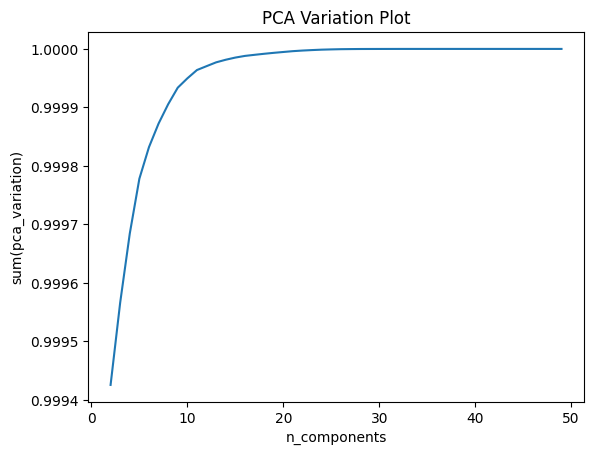

In [ ]:
pd.Series(pca_var_ratio).plot(title='PCA Variation Plot',
                              xlabel="n_components",
                              ylabel="sum(pca_variation)")

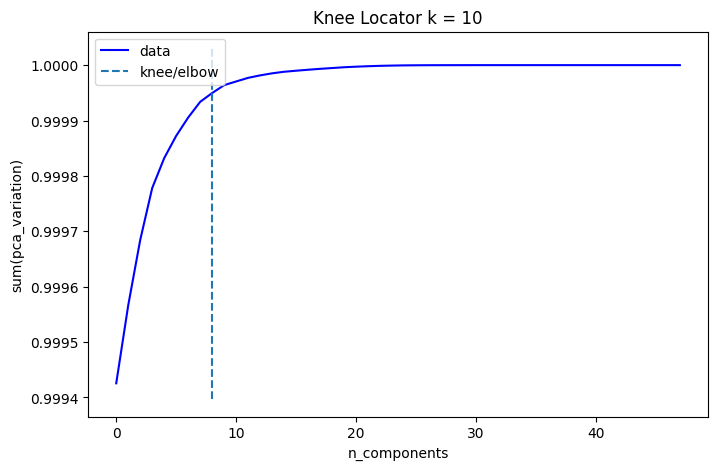

In [ ]:
i = np.arange(len(pca_var_ratio))
variance_ratio = list(pca_var_ratio.values())
components = list(pca_var_ratio.keys())

# Kneed algorithm to find the elbow point
knee = KneeLocator(i, variance_ratio, S=1, curve='concave',
                   interp_method='polynomial')
k = components[knee.knee]    # type: ignore

knee.plot_knee((8, 5), f'Knee Locator k = {k}', 
               "n_components", "sum(pca_variation)")
plt.show()

In [12]:
# Perform PCA with `n_components=18`
pca = PCA(n_components=12, random_state=42)
X_pca_transformed = pca.fit_transform(X_transformed)

### Balancing the Imbalanced

In [13]:
smt = SMOTETomek(random_state=42, sampling_strategy='minority')
X_resample, y_resample = smt.fit_resample(X_pca_transformed, y_transformed) # type: ignore

In [14]:
X_resample.shape, y_resample.shape

((117282, 12), (117282,))

## Train models

In [15]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    'XGB': XGBClassifier(),
}

In [16]:
models_list, models_scores_report, confusion_matrix_report = build_model_report(X_resample, y_resample, models)

Random Forest       : Training Scores
------------------------------------------------------
accuracy_score      : 0.998
f1_score            : 0.998
precision_score     : 1.000
recall_score        : 0.997
roc_auc_score       : 0.998
Random Forest       : Testing Scores
------------------------------------------------------
accuracy_score      : 0.984
f1_score            : 0.984
precision_score     : 0.979
recall_score        : 0.988
roc_auc_score       : 0.984
Gradient Boosting   : Training Scores
------------------------------------------------------
accuracy_score      : 0.928
f1_score            : 0.929
precision_score     : 0.929
recall_score        : 0.929
roc_auc_score       : 0.928
Gradient Boosting   : Testing Scores
------------------------------------------------------
accuracy_score      : 0.926
f1_score            : 0.925
precision_score     : 0.922
recall_score        : 0.929
roc_auc_score       : 0.926
AdaBoost Classifier : Training Scores
--------------------------------

### Display Trianing and Testing Reports

In [17]:
def plot_confusion_matrix(matrix_dict: dict[str, dict[str, np.ndarray]]):
    _, axes = plt.subplots(len(matrix_dict), 2, figsize=(12, 10))
    plt.tight_layout()

    for l, (model_name, d) in enumerate(matrix_dict.items()):
        for i, (type, matrix) in enumerate(d.items()):
            sns.heatmap(matrix, ax=axes[l, i], cbar=False, annot=True, fmt='d')
            axes[l, i].set_title(f'{model_name} : {type.title()}set')

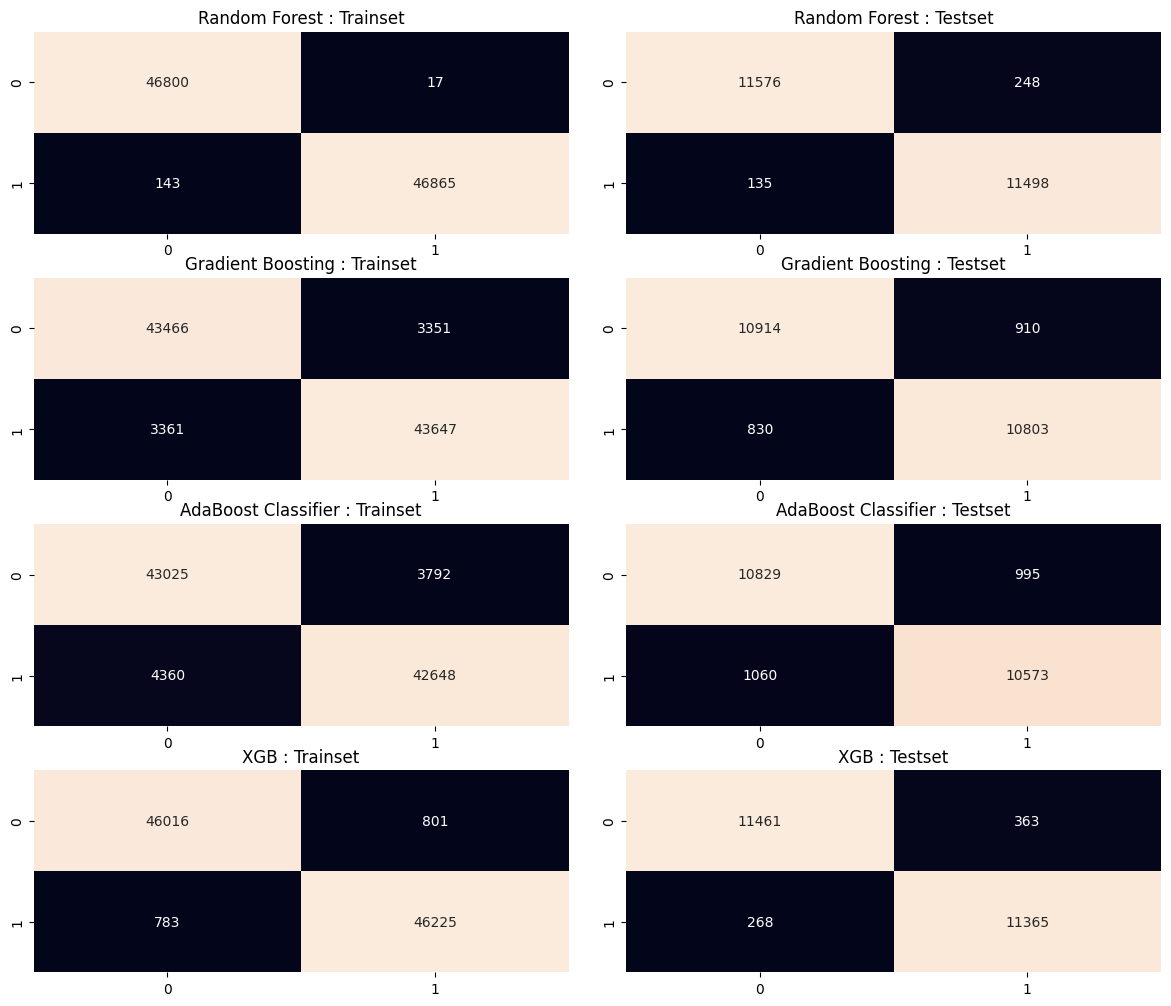

In [18]:
plot_confusion_matrix(confusion_matrix_report)